In [18]:
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
import corner
import emcee
import json

In [19]:
pfile = "../tests/files/real_mini_mcmc.json"
with open(pfile) as f:
    mcmc_dict = json.load(f)

# Select from dictionary the necessary parameters to be changed
# labels = mcmc_dict['mcmc']['parameter_order']

# labels = ["sfr_n", "alpha", "lmean", "lsigma", "lEmax", "gamma", "H0"]
# filenames = ["../mcmc/base_params"]
# filenames = ['../mcmc/w32_s1000_1', '../mcmc/w32_s1000_2', '../mcmc/w32_s1000_3', '../mcmc/w32_s1000_4']

# labels = ["sfr_n", "alpha", "lmean", "lsigma", "lEmax", "gamma", "H0", "DMhalo"]
# filenames = ['../mcmc/DMhalo3']
# filenames = ['mcmc/DMhalo', 'mcmc/DMhalo2']

# labels = ["sfr_n", "alpha", "lmean", "lsigma", "lEmax", "gamma", "H0", "uDMG"]
# filenames = ["../mcmc/uDMG"]

# labels = ["sfr_n", "alpha", "lmean", "lsigma", "lEmax", "gamma", "H0", "DMhalo", "uDMG"]
# filenames = ["../mcmc/test2"]

# labels = ["sfr_n", "alpha", "lmean", "lsigma", "lEmax", "gamma", "H0", "lEmin"]
# filenames = ['../mcmc/FASTnpCRAFT2', '../mcmc/FASTnpCRAFT3', '../mcmc/FASTnpCRAFT4']
# filenames = ['../mcmc/FASTnCRAFT4']

# labels = ["F", "sfr_n", "alpha", "lmean", "lsigma", "lEmax", "gamma", "H0", "lEmin"]
# filenames = ['../mcmc/FASTnpCRAFT_F']

labels = ["F", "sfr_n", "alpha", "lmean", "lsigma", "lEmax", "gamma", "H0", "lEmin", "DMhalo", "uDMG"]
filenames = ['../mcmc/FASTnpCRAFT_all']

# filenames = ['mcmc/FAST3']
# filenames = ['mcmc/Emin2', 'mcmc/Emin3']
# filenames = ['mcmc/FAST', 'mcmc/FAST2']

samples = []

for filename in filenames:
    reader = emcee.backends.HDFBackend(filename + '.h5')
    samples.append(reader.get_chain())

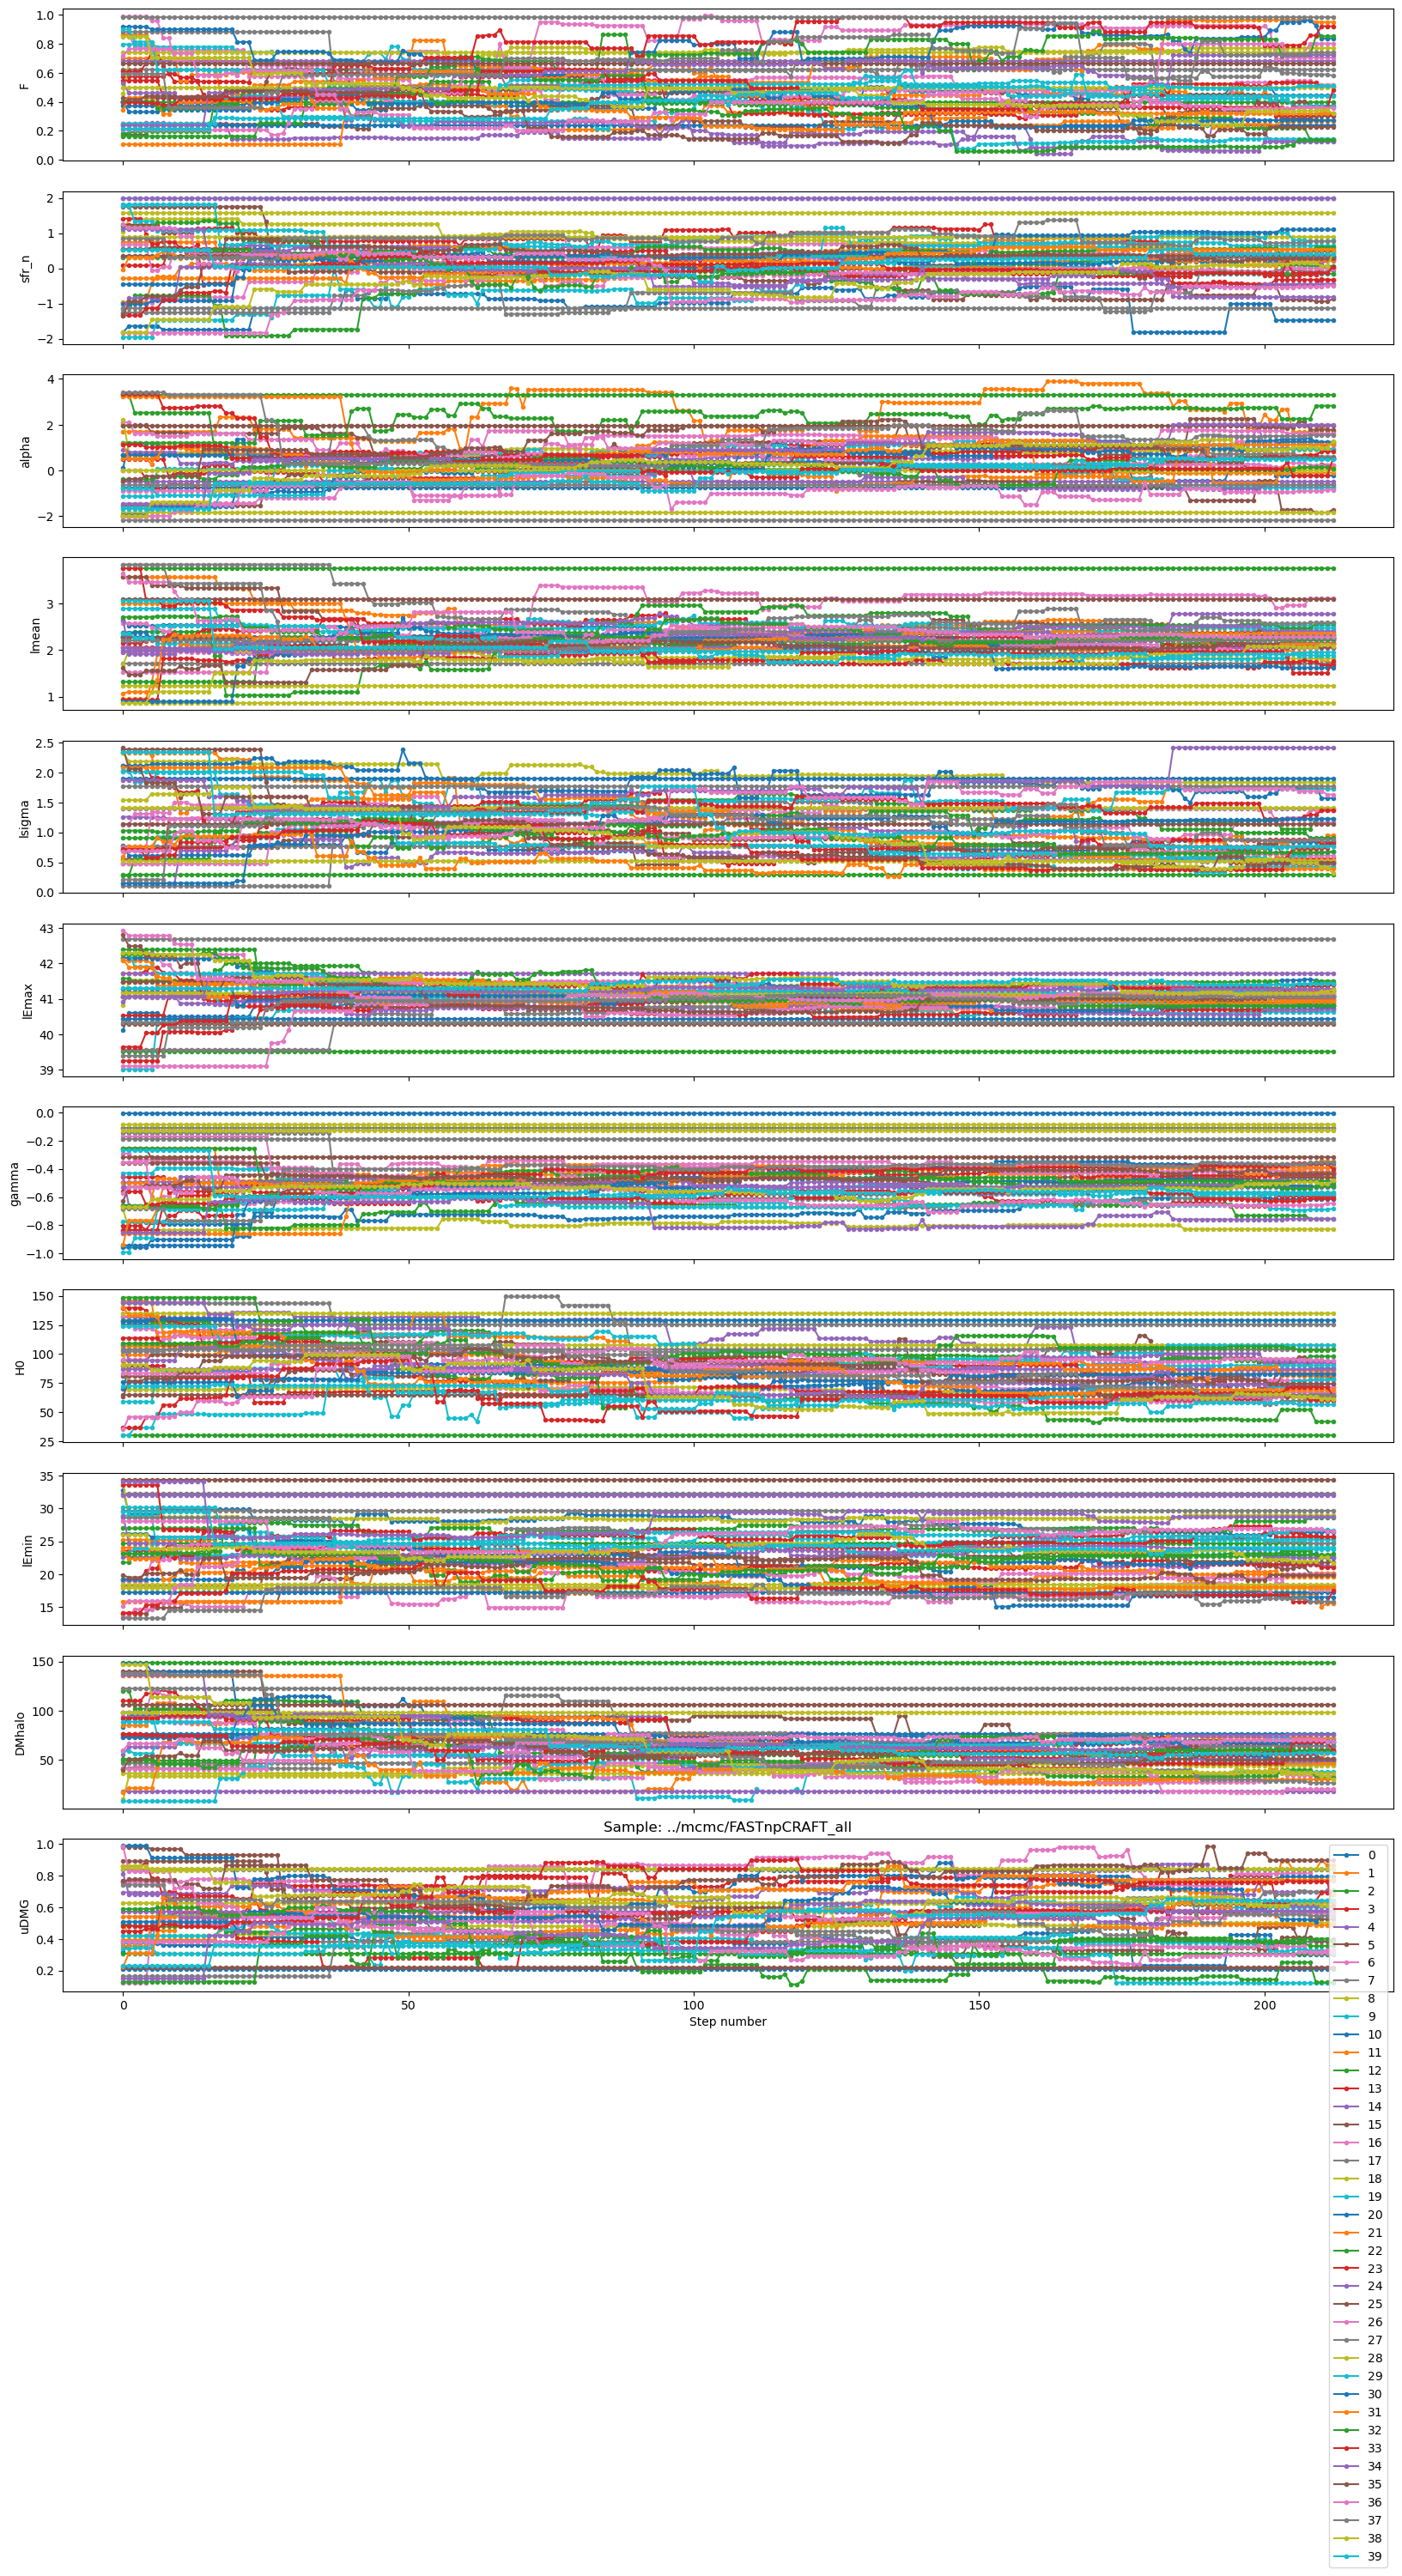

In [20]:
for j,sample in enumerate(samples):
    fig, axes = plt.subplots(sample.shape[2], 1, figsize=(20,30), sharex=True)
    plt.title("Sample: " + filenames[j])
    for i,ax in enumerate(axes):
        for k in range(sample.shape[1]):
            ax.plot(sample[:,k,i], '.-', label=str(k))

        ax.set_ylabel(labels[i])
    
    axes[-1].set_xlabel("Step number")
    axes[-1].legend()


In [21]:
# https://emcee.readthedocs.io/en/stable/tutorials/autocorr/#a-more-realistic-example
def next_pow_two(n):
    i = 1
    while i < n:
        i = i << 1
    return i

def autocorr_func_1d(x, norm=True):
    x = np.atleast_1d(x)
    if len(x.shape) != 1:
        raise ValueError("invalid dimensions for 1D autocorrelation function")
    n = next_pow_two(len(x))

    # Compute the FFT and then (from that) the auto-correlation function
    f = np.fft.fft(x - np.mean(x), n=2 * n)
    acf = np.fft.ifft(f * np.conjugate(f))[: len(x)].real
    acf /= 4 * n

    # Optionally normalize
    if norm:
        acf /= acf[0]

    return acf

# Automated windowing procedure following Sokal (1989)
def auto_window(taus, c):
    m = np.arange(len(taus)) < c * taus
    if np.any(m):
        return np.argmin(m)
    return len(taus) - 1

def autocorr(y, c=5.0):
    f = np.zeros(y.shape[1])
    for yy in y:
        f += autocorr_func_1d(yy)
    f /= len(y)
    taus = 2.0 * np.cumsum(f) - 1.0
    window = auto_window(taus, c)
    return taus[window]

# def autocorr_ml(y, thin=1, c=5.0):
#     # Compute the initial estimate of tau using the standard method
#     init = autocorr(y, c=c)
#     z = y[:, ::thin]
#     N = z.shape[1]

#     # Build the GP model
#     tau = max(1.0, init / thin)
#     kernel = terms.RealTerm(
#         np.log(0.9 * np.var(z)),
#         -np.log(tau),
#         bounds=[(-5.0, 5.0), (-np.log(N), 0.0)],
#     )
#     kernel += terms.RealTerm(
#         np.log(0.1 * np.var(z)),
#         -np.log(0.5 * tau),
#         bounds=[(-5.0, 5.0), (-np.log(N), 0.0)],
#     )
#     gp = celerite.GP(kernel, mean=np.mean(z))
#     gp.compute(np.arange(z.shape[1]))

    # # Define the objective
    # def nll(p):
    #     # Update the GP model
    #     gp.set_parameter_vector(p)

    #     # Loop over the chains and compute likelihoods
    #     v, g = zip(*(gp.grad_log_likelihood(z0, quiet=True) for z0 in z))

    #     # Combine the datasets
    #     return -np.sum(v), -np.sum(g, axis=0)

    # # Optimize the model
    # p0 = gp.get_parameter_vector()
    # bounds = gp.get_parameter_bounds()
    # soln = minimize(nll, p0, jac=True, bounds=bounds)
    # gp.set_parameter_vector(soln.x)

    # # Compute the maximum likelihood tau
    # a, c = kernel.coefficients[:2]
    # tau = thin * 2 * np.sum(a / c) / np.sum(a)
    # return tau

In [22]:
# Reject walkers with bad autocorrelation values
def auto_corr_rej(samples, burnin=0):
    good_samples = []

    # Loop through each sample and generate a list of good walkers and bad walkers
    for j,sample in enumerate(samples): 
        # burnin=200
        good_walkers = []
        bad_walkers = []


        # for i in range(sample.shape[1]):
        #     # if np.all(sample[burnin:burnin+30,i,0] == sample[burnin,i,0]):
        #     if ( np.std(sample[burnin:burnin+30,i,0] ) )
        #         bad_walkers.append(i)
        #     else:
        #         good_walkers.append(i)

        # Loop through each walker in the current sample
        for i in range(sample.shape[1]):
            bad = False

            # Loop through each parameter for the walker
            for k in range(sample.shape[2]):

                # If any of the parameters have a bad autocorrelation function then set as a bad walker
                acf = autocorr_func_1d(sample[burnin:,i,k], norm=False)
                if np.max(acf) < 1e-10:
                    bad = True
                    break

            if bad:
                bad_walkers.append(i)
            else:
                good_walkers.append(i)
            
            # fig = plt.figure()
            # plt.title(str(j) + ", " + str(i))
            # ax = fig.add_subplot(1,1,1)
            # ax.plot(acf)

        print("Discarded walkers for sample " + str(j) + ": " + str(bad_walkers))

        # Add the new sample with the bad walkers discarded to the good_samples list
        good_samples.append(sample[burnin:,good_walkers,:])

    return good_samples

# Reject walkers with small standard deviations
def std_rej(samples, burnin=0):
    good_samples = []

    if not type(burnin) == list:
        burnin = [burnin for i in range(len(samples))]

    # Loop through each sample
    for i, sample in enumerate(samples):
        bad_walkers = []
        good_walkers = []

        # For each parameter
        for k in range(sample.shape[2]):
            sd = []

            # Loop through every walker and get a list of the standard deviations
            for j in range(sample.shape[1]):
                sd.append(np.std(sample[burnin[i]:burnin[i]+100,j,k]))
            
            # Normalise standard deviation
            sd = sd / np.max(sd)

            # Flag any walkers with standard deviations less than 1e-2
            # bad_walkers = np.flatnonzero(sd < 1e-2)
            # temp = []
            for m in range(len(sd)):
                if sd[m] < 1e-2:
                    bad_walkers.append(m)
            # bad_walkers.append(temp)
            # bad_walkers.append([m if sd[m] < 1e-2 else _ for m in range(len(sd))])
        
        bad_walkers = np.unique(np.array(bad_walkers))

        print("Discarded walkers for sample " + str(i) + ": " + str(bad_walkers))
        for l in range(sample.shape[1]):
            if l not in bad_walkers:
                good_walkers.append(l)

        # Add the new sample with the bad walkers discarded to the good_samples list
        good_samples.append(sample[burnin[i]:,good_walkers,:])
    
    return good_samples

In [23]:
good_samples = std_rej(samples, burnin=0)
# good_samples = samples
# _ = auto_corr_rej(samples, burnin=0)

Discarded walkers for sample 0: [ 2  7 10 14 18 25 27 28]


(213, 32, 11)


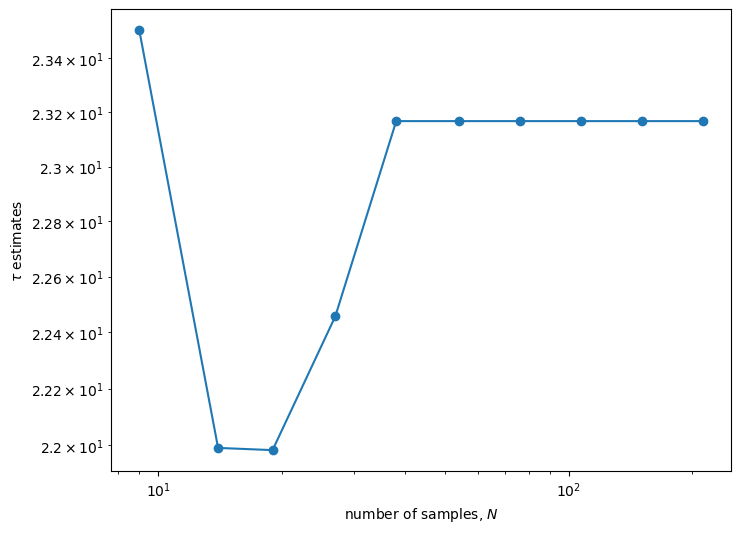

In [24]:
burnin = []
for sample in good_samples:
    print(sample.shape)
    # Compute the estimators for a few different chain lengths
    N = np.exp(np.linspace(np.log(10), np.log(sample.shape[0]), 10)).astype(int)
    new = np.empty(len(N))
    for i, n in enumerate(N):
        new[i] = autocorr(sample[:, :n, 0].T)

    # Plot the comparisons
    fig, ax = plt.subplots(1,1,figsize=(8,6))
    ax.loglog(N, new, "o-", label="new")
    ylim = ax.get_ylim()
    ax.plot(N, N / 50.0, "--k", label=r"$\tau = N/50$")
    ax.set_ylim(ylim)
    ax.set_xlabel("number of samples, $N$")
    ax.set_ylabel(r"$\tau$ estimates")
    # ax.legend(fontsize=14);

    burnin.append(int(1.5*new[-1]))

In [25]:
# good_samples = std_rej(samples, burnin=200)
# _ = auto_corr_rej(samples, burnin=burnin)

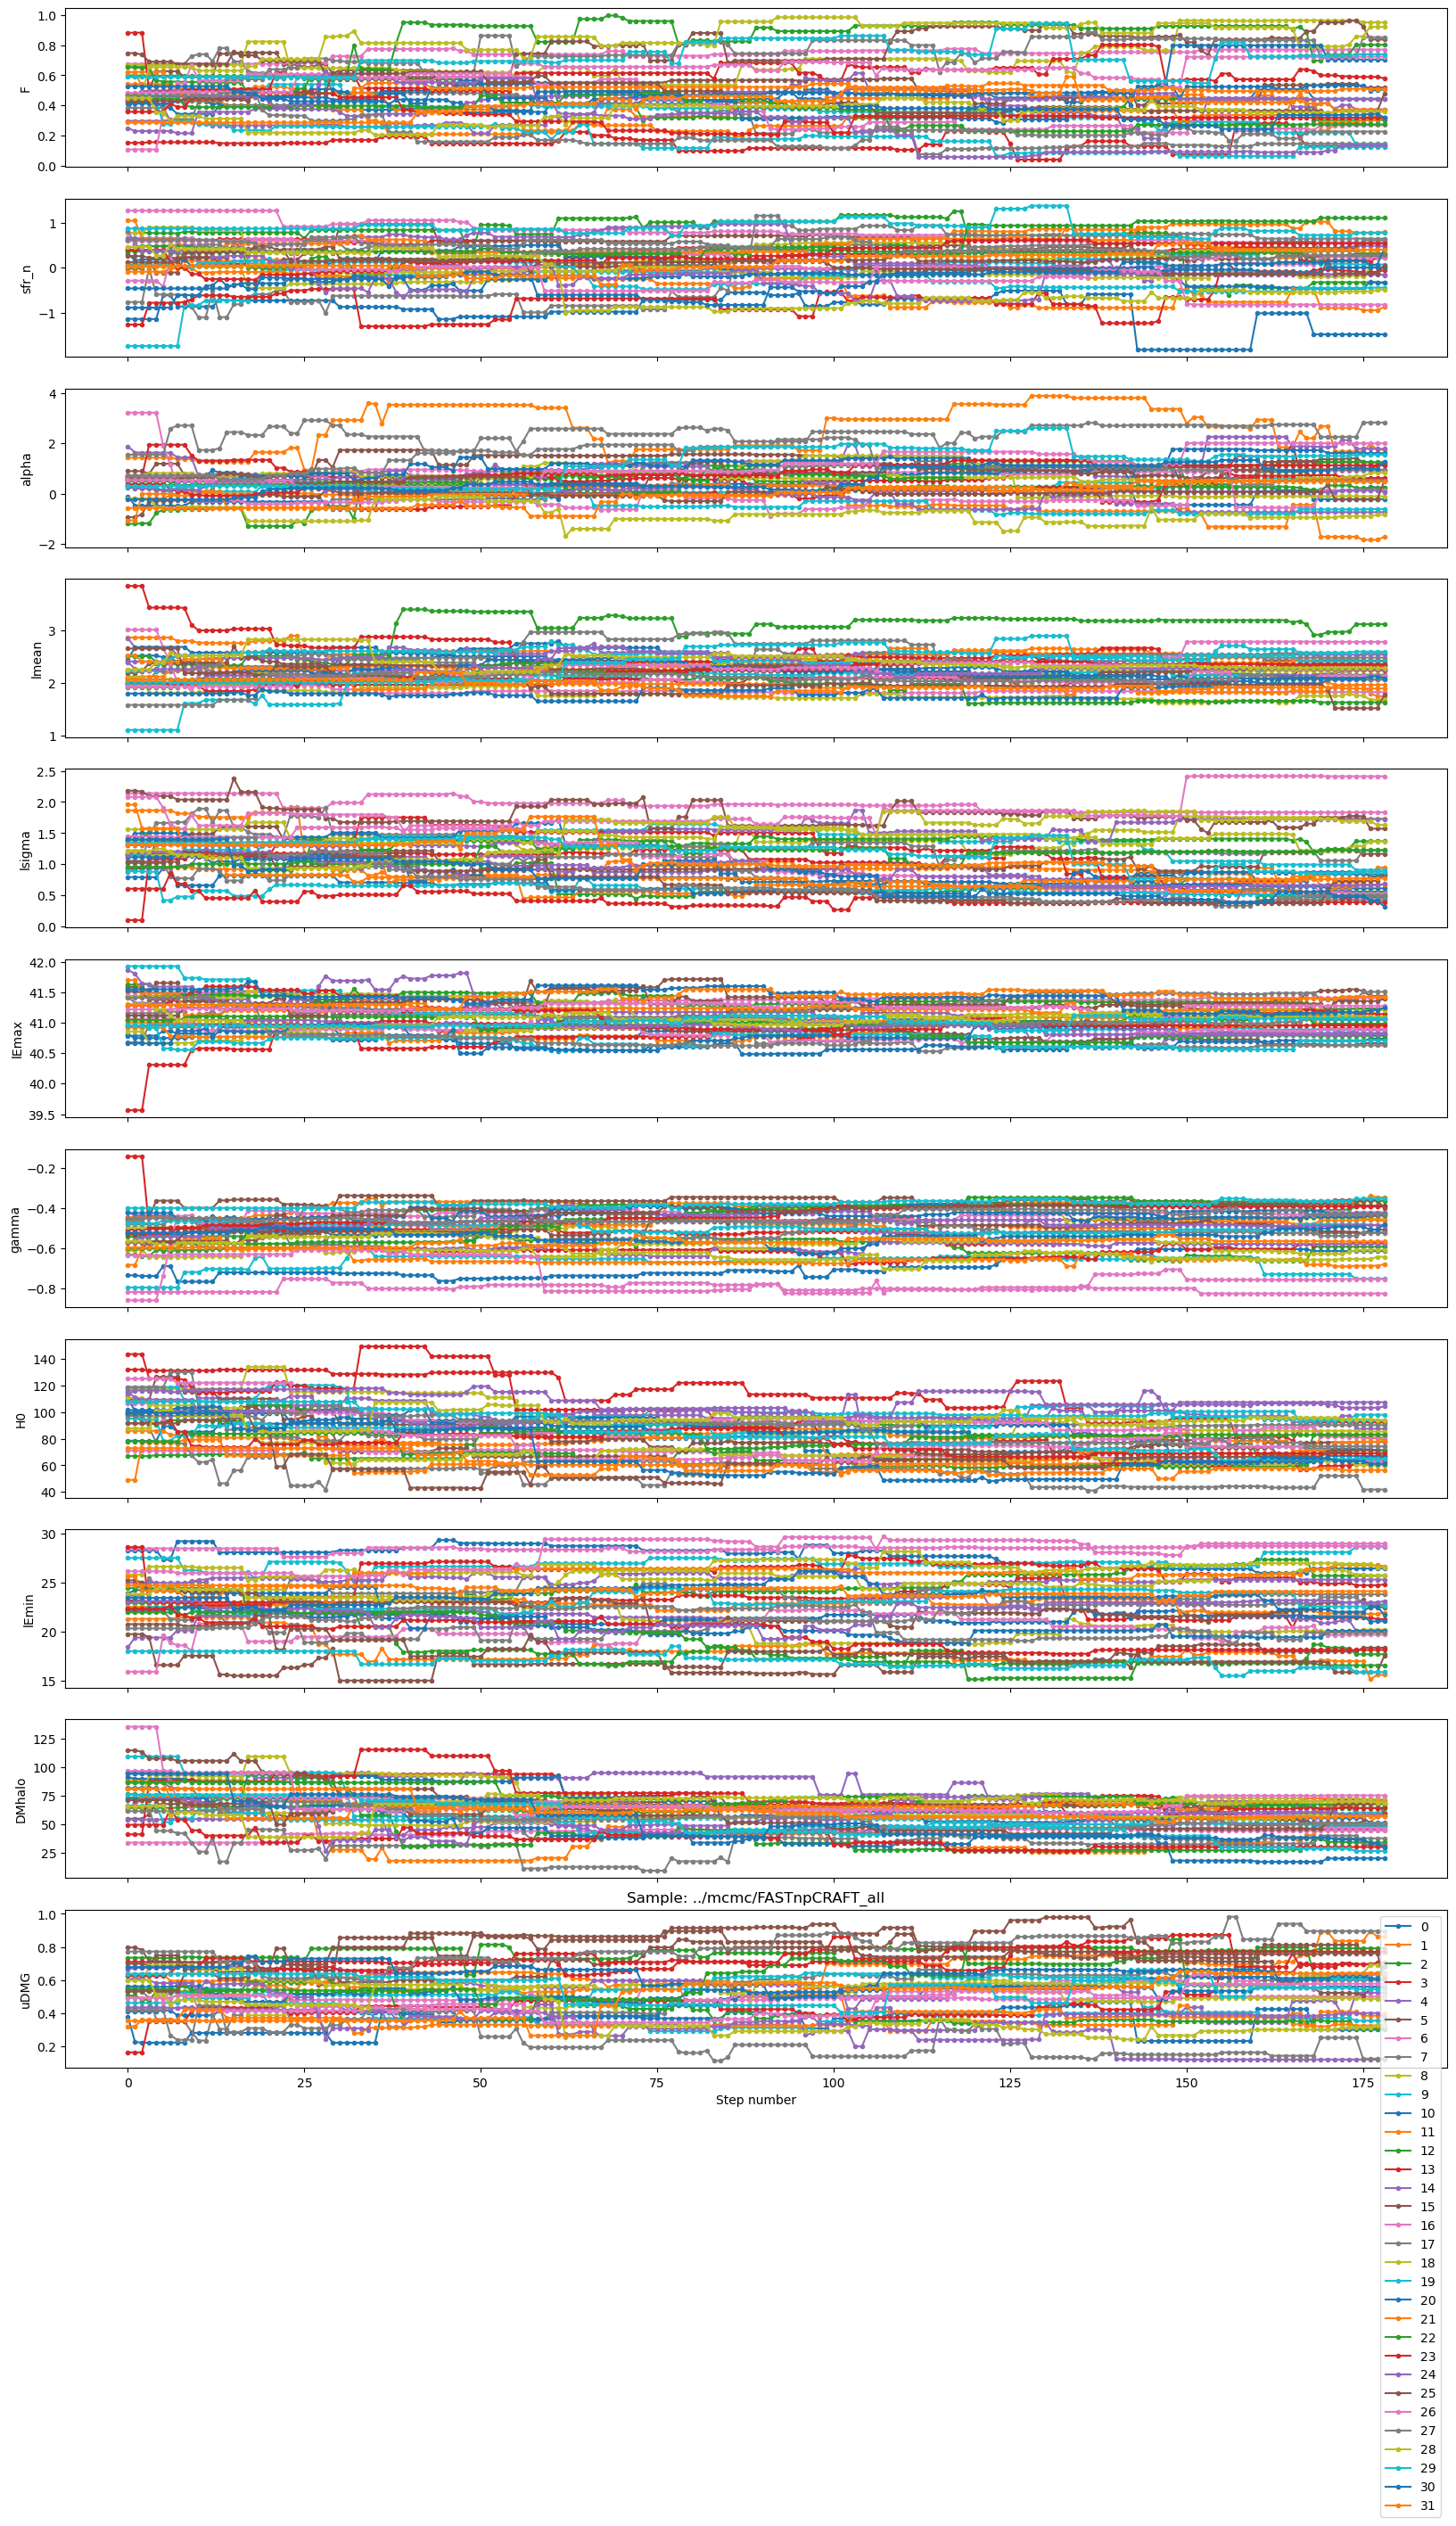

In [26]:
for j,sample in enumerate(good_samples):
    fig, axes = plt.subplots(sample.shape[2], 1, figsize=(20,30), sharex=True)
    plt.title("Sample: " + filenames[j])
    for i,ax in enumerate(axes):
        for k in range(sample.shape[1]):
            ax.plot(sample[burnin[j]:,k,i], '.-', label=str(k))

        ax.set_ylabel(labels[i])
    
    axes[-1].set_xlabel("Step number")
    axes[-1].legend()


In [27]:
# Enforce more restrictive priors on a parameter
def change_priors(sample, param_num, max=np.inf, min=-np.inf):

    condition = np.logical_and(sample[:,param_num] > min, sample[:,param_num] < max)
    good_idxs = np.flatnonzero(condition)

    return sample[good_idxs, :]

In [35]:
# Get the final sample without burnin and without bad walkers
final_sample = [[] for i in range(samples[0].shape[2])]
print(burnin)
# burnin=[15]

for j,sample in enumerate(good_samples):
    for i in range(sample.shape[2]):
        final_sample[i].append(sample[burnin[j]:,:,i].flatten())
final_sample = np.array([np.hstack(final_sample[i]) for i in range(len(final_sample))]).T

# final_sample = change_priors(final_sample, 2, min=1.0)
# final_sample = change_priors(final_sample, 3, max=2.0)
# final_sample = change_priors(final_sample, 1, max=1.0, min=-3.5)

print(final_sample.shape)


[34]
(5216, 11)


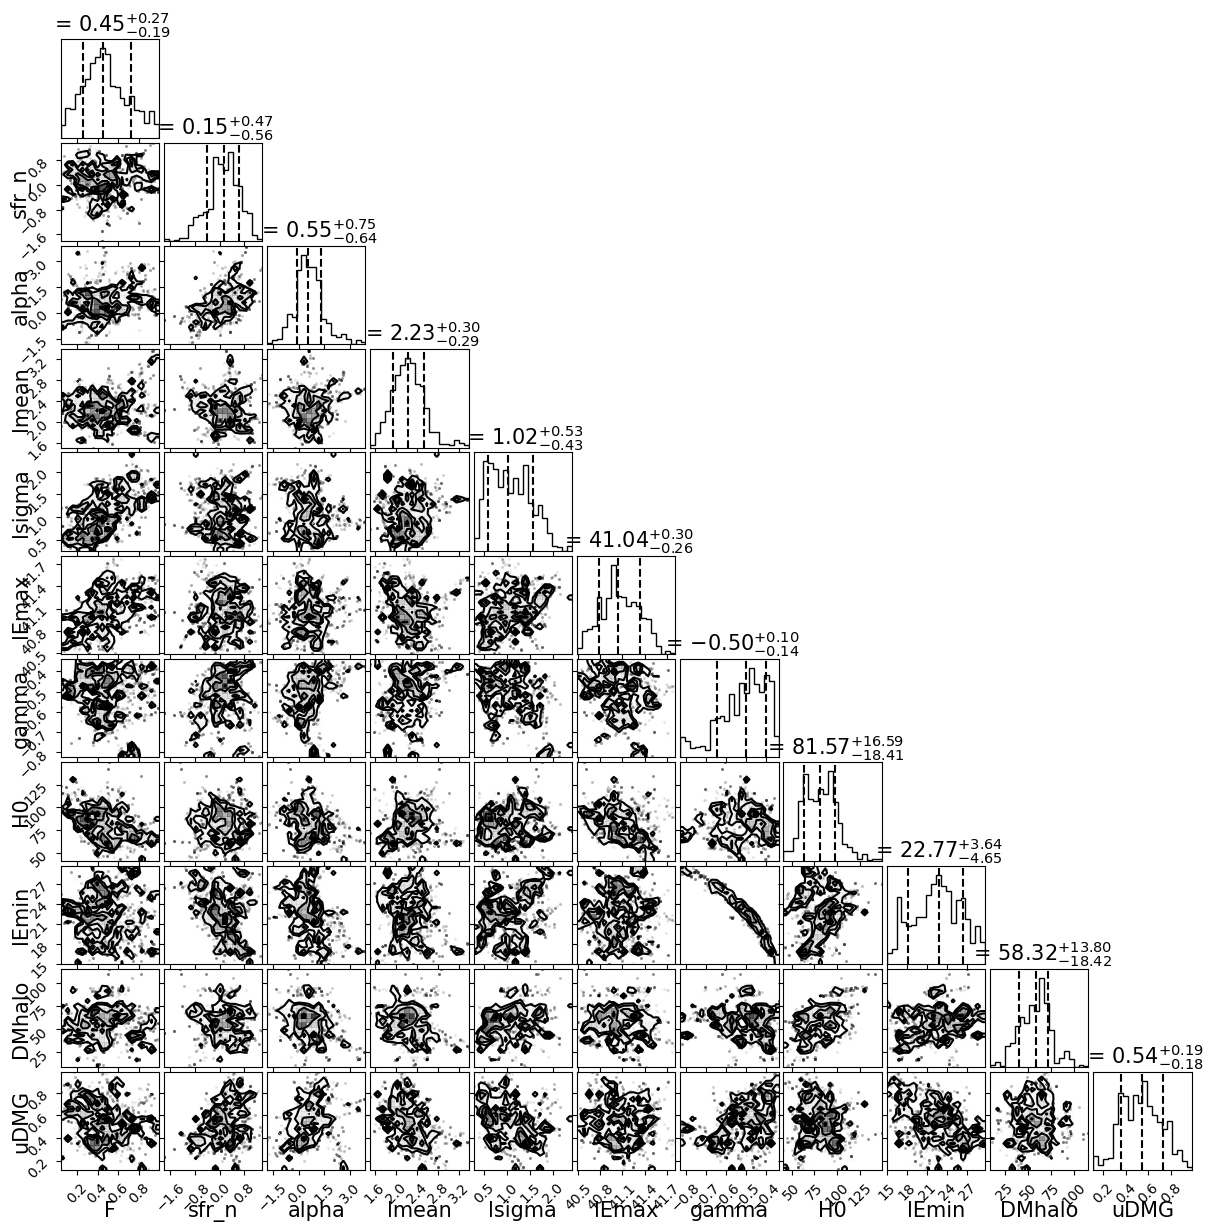

In [36]:
fig = plt.figure(figsize=(12,12))
titles = ['' for i in range(final_sample.shape[1])]
corner.corner(final_sample,labels=labels, show_titles=True, titles=titles, fig=fig,title_kwargs={"fontsize": 15},label_kwargs={"fontsize": 15}, quantiles=[0.16,0.5,0.84]);

F: 0.45492015376118444 (-0.18803384916940624/+0.2538051414056093)
sfr_n: 0.1503629752347999 (-0.5661511528671979/+0.47151893331700134)
alpha: 0.5330289153121683 (-0.647255765722893/+0.7496163699468814)
lmean: 2.2231281584982012 (-0.2826092789078978/+0.30325587599874027)
lsigma: 1.0509022563615362 (-0.4492640116603601/+0.5100693676213792)
lEmax: 41.05315277763536 (-0.26734689049011706/+0.31179560479375823)
gamma: -0.5028034331813074 (-0.1377735927186976/+0.10111161676036351)
H0: 82.87129671183196 (-19.230075178906382/+17.752764786741366)
lEmin: 22.771173728591414 (-4.279336911029738/+3.5864926161983384)
DMhalo: 60.06225586515502 (-19.644156517606447/+13.799465312717679)
uDMG: 0.541470821882888 (-0.18069082708923456/+0.1835060874524237)


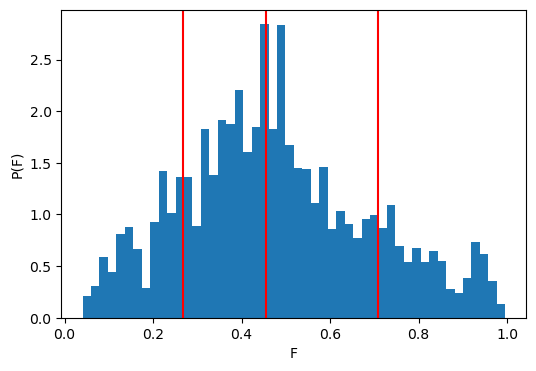

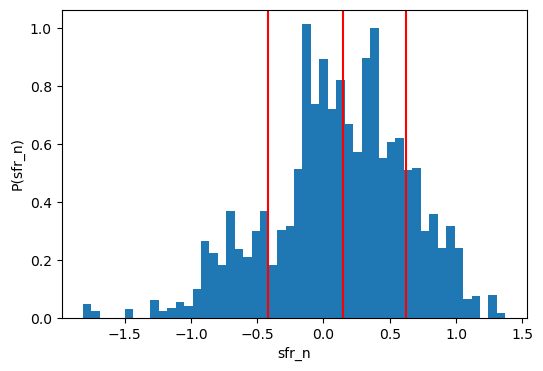

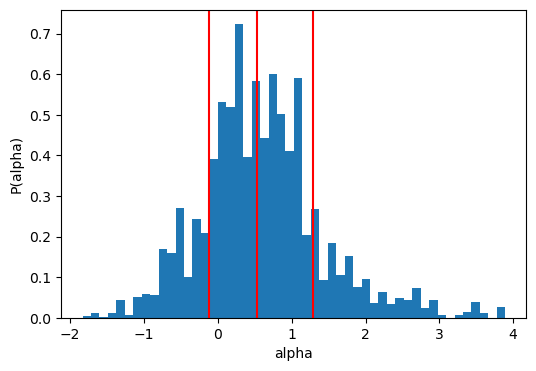

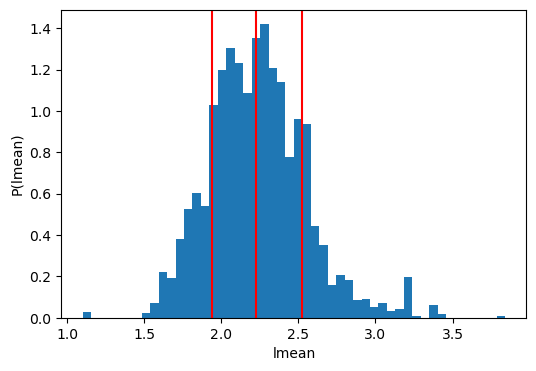

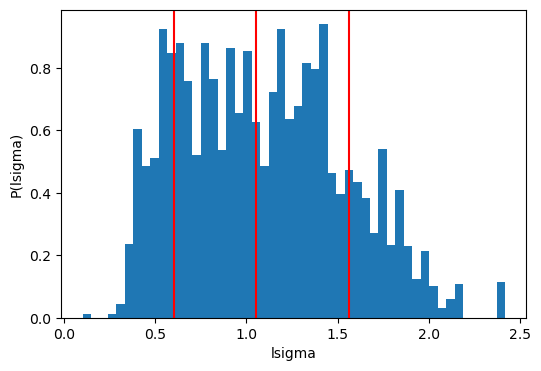

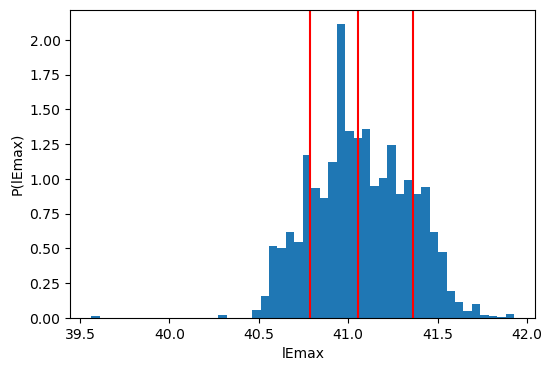

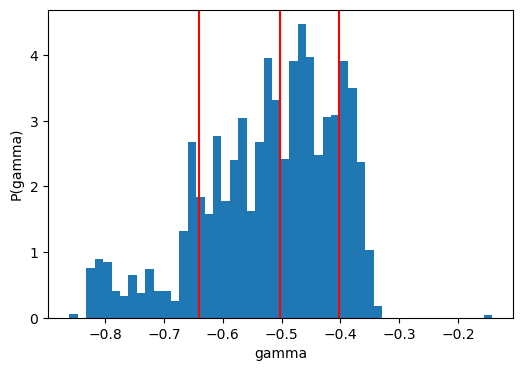

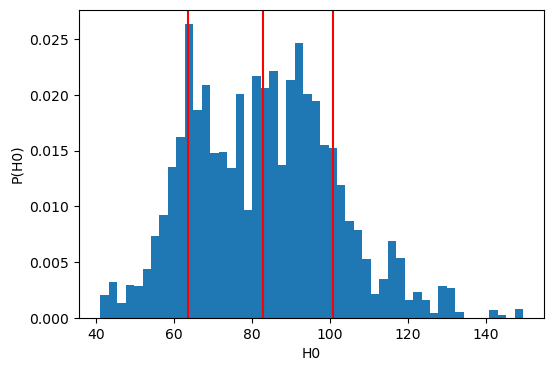

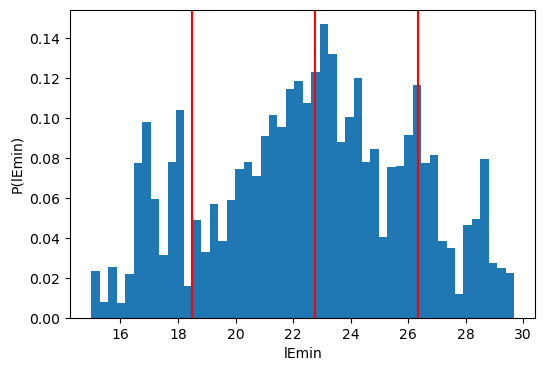

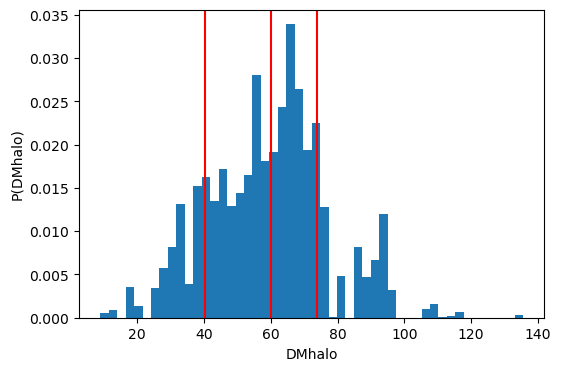

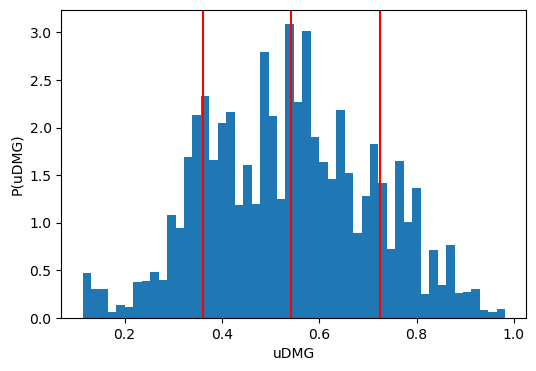

In [30]:
nBins = 50
win_len = int(nBins/10)
CL = 0.68

best_fit = {}

for i in range(len(labels)):
    fig = plt.figure(figsize=(6,4))
    ax = fig.add_subplot(1,1,1)
    hist, bin_edges, _ = ax.hist(final_sample[:,i], bins=nBins, density=True)
    bin_width = bin_edges[1] - bin_edges[0]
    bins = -np.diff(bin_edges)/2.0 + bin_edges[1:]

    ax.set_xlabel(labels[i])
    ax.set_ylabel("P("+labels[i]+")")

    # # Use mode
    # ordered_idxs = np.argsort(hist)

    # sum = hist[ordered_idxs[0]] * bin_width
    # j = 1
    # while(sum < 1-CL):
    #     sum += hist[ordered_idxs[j]] * bin_width
    #     j = j+1

    # best = bins[ordered_idxs[-1]]
    # lower = bins[np.min(ordered_idxs[j:])]
    # upper = bins[np.max(ordered_idxs[j:])]

    # Use median
    best = np.quantile(final_sample[:,i], 0.5)
    lower = np.quantile(final_sample[:,i], 0.16)
    upper = np.quantile(final_sample[:,i], 0.84)

    best_fit[labels[i]] = best
    u_lower = best - lower
    u_upper = upper - best
    ax.axvline(lower, color='r')
    ax.axvline(best, color='r')
    ax.axvline(upper, color='r')
    print(f'{labels[i]}: {best} (-{u_lower}/+{u_upper})')

In [31]:
from zdm import survey
from zdm import cosmology as cos
from zdm.craco import loading
from zdm.misc_functions import *
import zdm.iteration as it

In [32]:
prefix='FASTnCRAFT'

cos.init_dist_measures()
state = loading.set_state()

# get the grid of p(DM|z)
zDMgrid, zvals,dmvals=get_zdm_grid(state,new=True,plot=False,method='analytic',save=True,datdir='MCMCData')

# Load surveys
with open('../Pickle/'+prefix+'surveys.pkl', 'rb') as infile:
    surveys=pickle.load(infile)
    names=pickle.load(infile)

# Load grids
with open('../Pickle/'+prefix+'grids.pkl', 'rb') as infile:
    grids=pickle.load(infile)

FAST.ecsv - expected, observed: 8.056977969275131, 4
CRAFT_class_I_and_II.ecsv - expected, observed: 15.752874517555313, 20
CRAFT_ICS.ecsv - expected, observed: 9.630219316973058, 13
CRAFT_ICS_892.ecsv - expected, observed: 10.26386814906908, 8
parkes_mb_class_I_and_II.ecsv - expected, observed: 5.331921436334728, 12


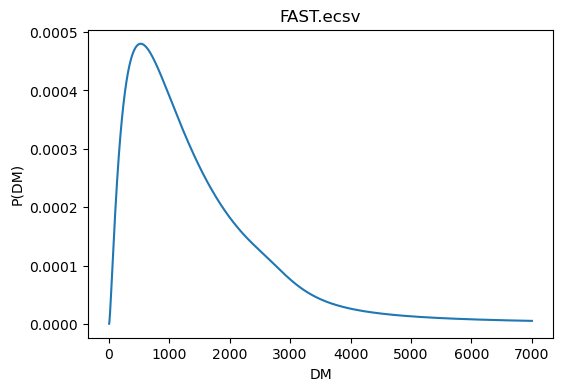

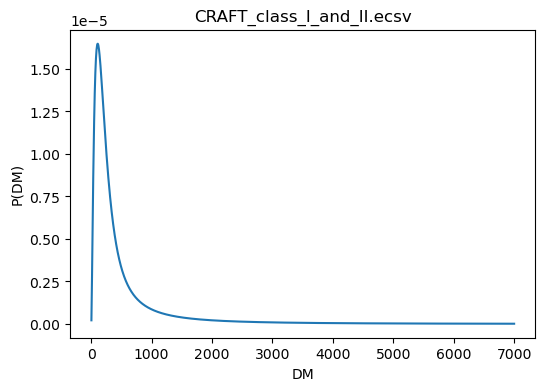

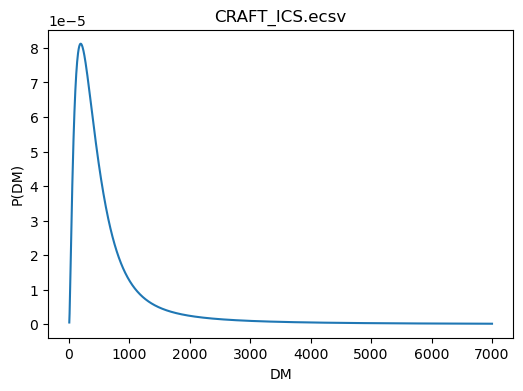

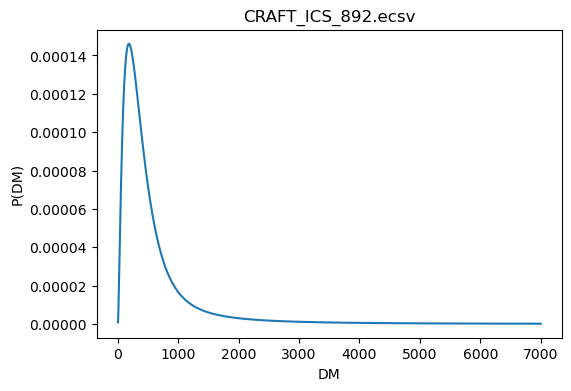

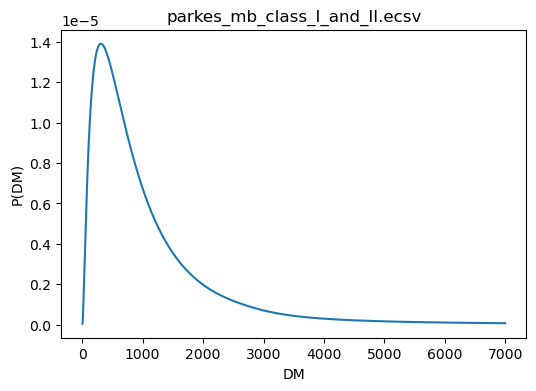

In [33]:
it.minimise_const_only(best_fit, grids, surveys)

for s,g in zip(surveys, grids):
    fig = plt.figure(figsize=(6,4))
    ax = fig.add_subplot(1,1,1)

    ax.set_title(s.name)
    ax.set_xlabel("DM")
    ax.set_ylabel("P(DM)")

    rates=g.rates
    dmvals=g.dmvals
    pdm=np.sum(rates,axis=0)

    ax.plot(dmvals, pdm)

    expected=it.CalculateIntegral(g,s)
    expected *= 10**g.state.FRBdemo.lC
    observed=s.NORM_FRB

    print(s.name + " - expected, observed: " + str(expected) + ", " + str(observed))

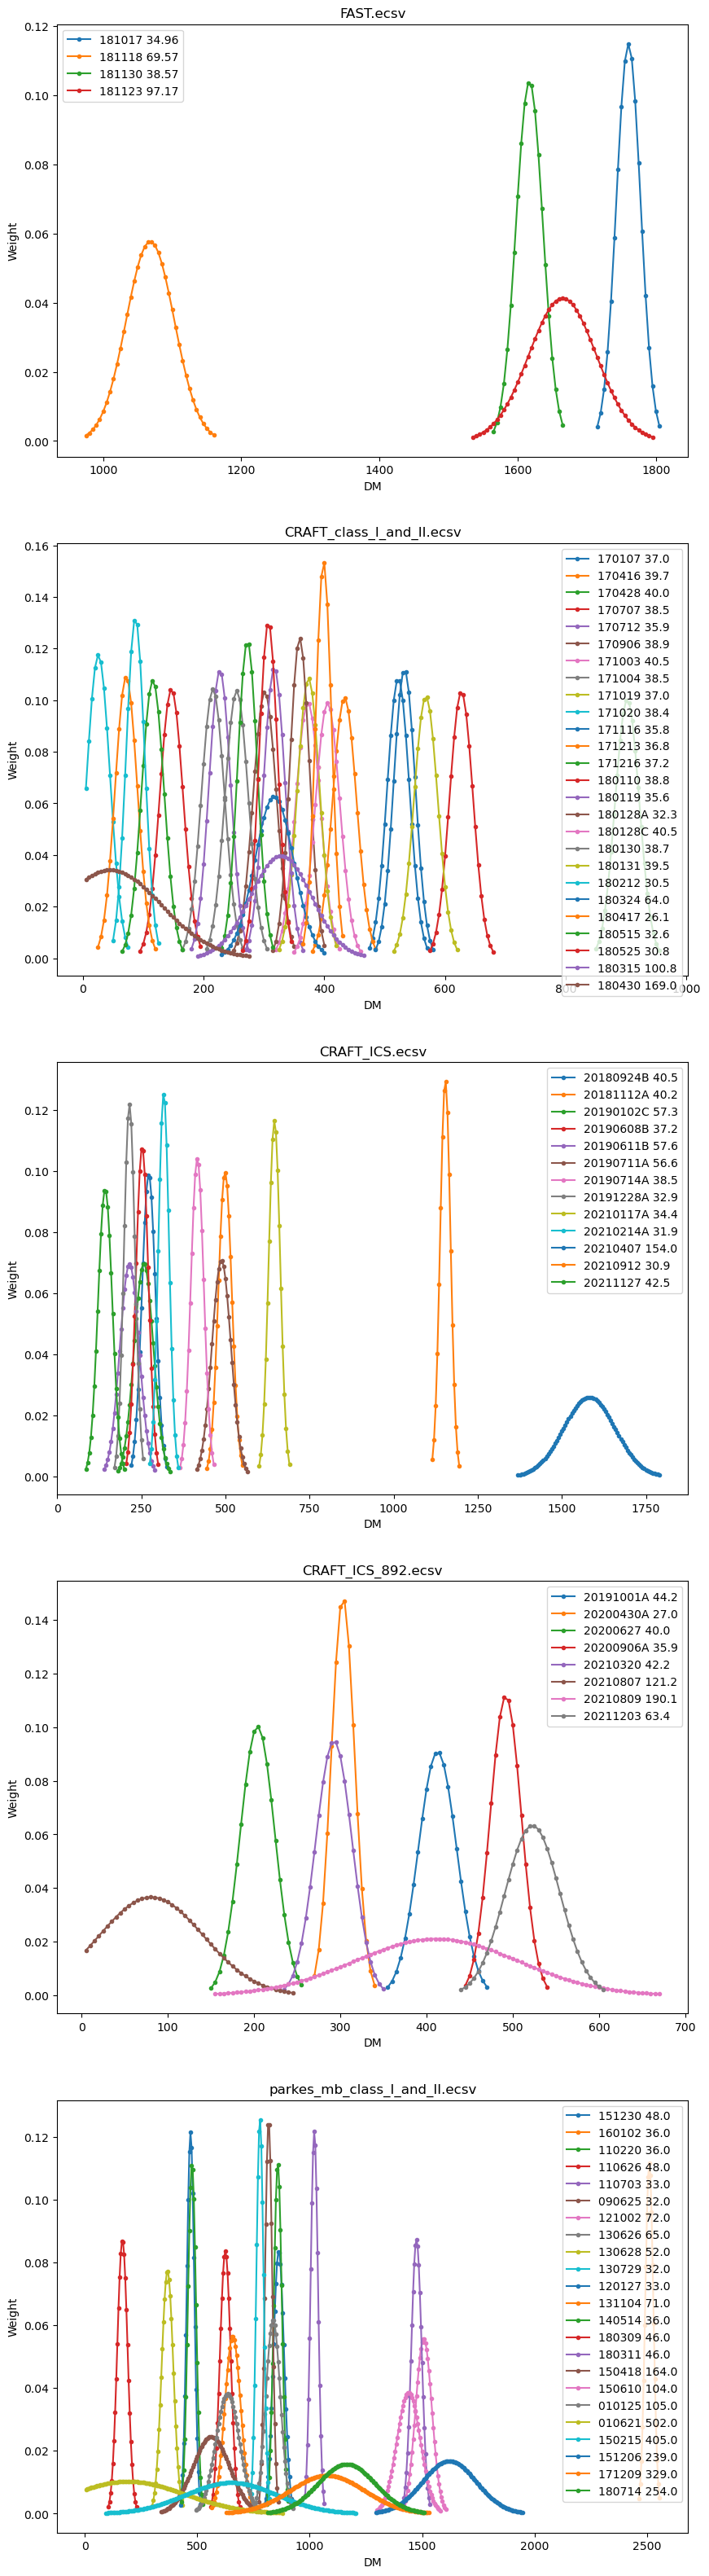

In [34]:
uDMGs = 0.5

fig = plt.figure(figsize=(10,40))

for j,(s,g) in enumerate(zip(surveys, grids)):
    ax = fig.add_subplot(len(surveys),1,j+1)
    plt.title(s.name)
    ax.set_xlabel('DM')
    ax.set_ylabel('Weight')

    rates=g.rates
    dmvals=g.dmvals
    zvals=g.zvals
    DMobs=s.DMEGs

    dm_weights, iweights = it.calc_DMG_weights(DMobs, s.DMGs, uDMGs, dmvals)
    for i in range(len(DMobs)):
        ax.plot(dmvals[iweights[i]], dm_weights[i], '.-', label=s.frbs["TNS"][i] + " " + str(s.DMGs[i]))

    ax.legend()
    